# TWAMP EXPERIMENTS

**Done by:** Tim Josefsson, Johan Gille, Jimmy Helmersson, Linus Hedberg, Tugce Dilan

*Computer Networks III - Uppsala University - Fall 2015*

*Latest Revision: 04/05/2016*

## Code for plotting and experiments

This section contains the code used to create plots and to convert received values from the experiments. This is of no particular interest unless you are interested in seeing how to create plots using Python.

In [1]:
#!/usr/bin/env python
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from collections import defaultdict
import csv

## Defines
clock_second = 128
volt_usage = 3
r_timer = 32768
 
# Main core
standby_state = 0.5 * pow(10,-6)
active_state = 8 * pow(10,-3) # this value is to be less than 10, probably in the range of 5-10
 
# Radio stuff
rx_state = 18.8 * pow(10,-3)
tx_state = 17.4 * pow(10,-3)

In [2]:
def convert_mA(values):
    out_values = []
    for value in values:
        value = ((value/1000.0)/volt_usage)*1000
        out_values.append(value)
    return out_values

In [3]:
# for P lines
#0-> str,
#1 -> clock_time(),2-> P, 3->rimeaddr_node_addr.u8[0],rimeaddr_node_addr.u8[1], 4-> seqno,
#5 -> all_cpu,6-> all_lpm,7-> all_transmit,8-> all_listen,9-> all_idle_transmit,10-> all_idle_listen,
#11->cpu,12-> lpm,13-> transmit,14-> listen, 15 ->idle_transmit, 16 -> idle_listen, [RADIO STATISTICS...]

def totalConsumption(filelist):
    cpu,lpm,tx,rx = [],[],[],[]
    for name in filelist:
        temp_cpu, temp_lpm, temp_tx, temp_rx = 0,0,0,0
        with open(name, 'rb') as f:
            reader = csv.reader(f,delimiter=' ')
            for row in reader:
                if row[2] is 'P': 
                    temp_cpu += (int(row[11])*(active_state*volt_usage))/r_timer
                    temp_lpm += (int(row[12])*(standby_state*volt_usage))/r_timer
                    temp_tx+= (int(row[13])*(active_state+tx_state)*volt_usage)/r_timer
                    temp_rx += (int(row[11])*(active_state+rx_state)*volt_usage)/r_timer
        cpu.append(temp_cpu)
        lpm.append(temp_lpm)
        tx.append(temp_tx)
        rx.append(temp_rx)
    return cpu, lpm, tx, rx

In [4]:
def mk_2bar_plot(values1, values2, labels,flag,xlabel,title):
    y_pos = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(y_pos,values1,width,color='#FAA43A')
    rects2 = ax.bar(y_pos,values2,width,bottom=values1,color='#DECF3F')
    
    ax.set_ylabel('Consumption (mA)')
    ax.set_xticks(y_pos + width/2)
    ax.set_xticklabels(labels)
    
    ax.set_xlabel(xlabel)
    ax.set_title(title)
     
    fontP = FontProperties()
    fontP.set_size('small')
    if flag==0:
        ax.legend((rects1[0], rects2[0]), ('Transmit','Listen'), prop = fontP, loc="upper left")
    if flag==1:
        ax.legend((rects1[0], rects2[0]), ('CPU','LPM'), prop = fontP, loc="upper left")
 
    plt.show()
    

In [11]:
def plot_drift(values):
    drifts, labels = [],[]
    with open(values, 'rb') as f:
            reader = csv.reader(f,delimiter=',')
            for row in reader:
                temp = abs(int(row[0])-int(row[1]))
                temp = round(temp/float(clock_second),3)
                drifts.append(temp)
                labels.append(float(row[2]))
    plt.title('Drift over time')
    plt.xlabel('Time (min)')
    plt.ylabel('Drift (ms)')
    plt.plot(labels, drifts, label='Drift')

    plt.legend(loc='upper left')

    plt.show()    

In [15]:
amount = ['logs/log_amount10.txt','logs/log_amount20.txt', 'logs/log_amount30.txt', 'logs/log_amount40.txt', \
          'logs/log_amount50.txt','logs/log_amount60.txt','logs/log_amount70.txt', 'logs/log_amount80.txt', \
          'logs/log_amount90.txt', 'logs/log_amount100.txt', 'logs/log_amount110.txt', 'logs/log_amount120.txt']
amount_labels = ('10', '20', '30','40','50','60', '70', '80','90','100','110','120')

time = ['logs/log_time1.txt','logs/log_time2.txt', 'logs/log_time4.txt', 'logs/log_time8.txt', 'logs/log_time16.txt']
time_labels = ('1', '2', '4','8','16')


## TWAMP Testsession Experiments

In this section we detail and present the experiments we've run and our reasons for running them, some thoughts and discussion about the results.

### Power consumption in correlation to amount of packets sent

**Purpose:** The purpose of this experiment is to determine how well the TWAMP test session scales with the amount of packets sent between the **Sender** and the **Reflector**.

**Setup:** 
* The measurements are done on the **Sender**. 
* The distance between **Sender** and **Reflector** was 40 cm.
* Packets were sent at a fixed interval, this interval was 4 seconds.
* The size of the packets sent were 42 octets

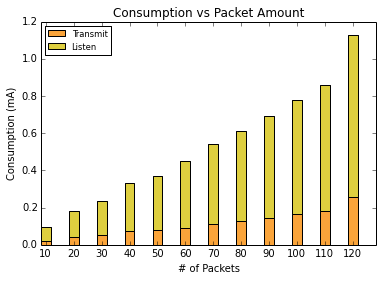

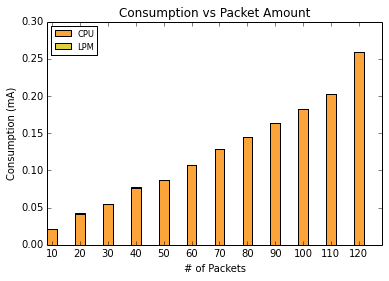

In [16]:
cpu,lpm,tx,rx = totalConsumption(amount)
mk_2bar_plot(convert_mA(tx),convert_mA(rx),amount_labels,0,'# of Packets','Consumption vs Packet Amount')
mk_2bar_plot(convert_mA(cpu),convert_mA(lpm),amount_labels,1,'# of Packets','Consumption vs Packet Amount')

### Power consumption in correlation to interval between sent packets

**Purpose:** The purpose of this experiment is to determine how well the TWAMP test session scales with the time elasped between each sent packet between the **Sender** and the **Reflector**.

**Setup:** 
* The measurements are done on the **Sender**. 
* The distance between **Sender** and **Reflector** was 40 cm.
* The number of packets sent were set to 15.
* The size of the packets sent were 42 octets

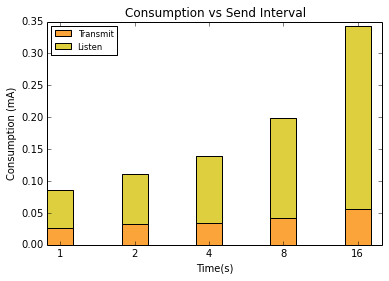

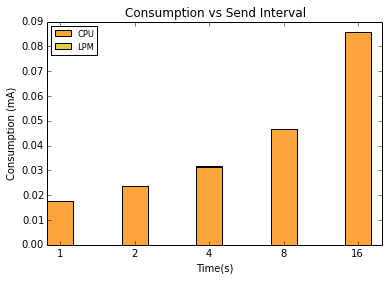

In [17]:
cpu,lpm,tx,rx = totalConsumption(time)
mk_2bar_plot(convert_mA(tx),convert_mA(rx),time_labels,0,'Time(s)','Consumption vs Send Interval')
mk_2bar_plot(convert_mA(cpu),convert_mA(lpm),time_labels,1,'Time(s)','Consumption vs Send Interval')

### Drift over time between Sender and Reflector

**Purpose:** The purpose of this experiment is to determine how much the Z1 motes drift after they have been synched to the same clock. This would be interesting since it would determine how often the motes would have to be resynched.

**Setup:** 
* The measurements are done on the **Sender** and the **Reflector**. 
* The distance between **Sender** and **Reflector** was 20 cm.
* One synchronization message was sent for the duration of the experiment, this was sent at the start.
* There was a total of 40 packets sent, excluding the synchronization message.
* Packets were sent at a fixed interval, this interval was 30 seconds.
* The size of the packets sent were 42 octets

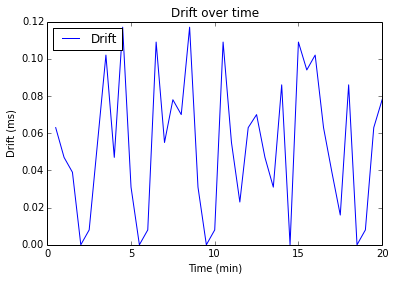

In [13]:
#plot_drift('drift10m.txt')
plot_drift('logs/drift20m.txt')

**Results:** We were quite suprised to see that the motes didn't drift more than ~0.1 ms apart with just one synchronization message. Granted this was just over a 20 minute period so it would be interesting to so how much they drift over say a week.